In [45]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt

## Data Cleaning and Preparation
In this first section, the raw data from my bank account is cleaned and transformed to make it usable for analysis and machine learning. The steps include handling missing values, dropping unnecessary rows or columns, and standardizing the data. Additionally, categories are created to classify spending into meaningful groups (e.g., "Essentials," "Entertainment", "Beauty"). These transformations ensure that the data is consistent, organized, and ready for further analysis and modeling

In [3]:
spending = pd.read_csv('spending_2024.csv', delimiter=';')

In [4]:
spending.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 333 entries, 0 to 332
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         333 non-null    object 
 1   Description  333 non-null    object 
 2   Amount       300 non-null    float64
dtypes: float64(1), object(2)
memory usage: 7.9+ KB


In [5]:
# Need to ignore paycheck
spending.drop(spending.loc[spending['Description'].str.contains(r'PAY CIUSSS DE L\' EST DE MONTREAL', na=False)].index, inplace=True)

In [6]:
spending.dropna(inplace=True) # Remove all the null values
print(spending.isna().sum()) # Checking if there is any lines with null values

Date           0
Description    0
Amount         0
dtype: int64


In [7]:
substring = 'RETAIL PURCHASE'
spending['Description'] = spending['Description'].apply(lambda line:line[line.find(substring):] if substring in line else line)

In [8]:
# I need to remove the payment code, it is irrelevant
def remove_numeric(substring):
    if substring.isnumeric() and len(substring) == 12:
        return ''
    return substring

spending['Description'] = spending['Description'].apply(
    lambda line: " ".join(remove_numeric(word) for word in line.split())
)


In [9]:
spending.head(5)

,Date,Description,Amount
0,2024-06-28,RETAIL PURCHASE SH VENDING80036,1.85
1,2024-06-27,RETAIL PURCHASE SUPER C PTE AUX,28.19
2,2024-06-27,RETAIL PURCHASE SH VENDING80036,3.15
3,2024-06-26,RETAIL PURCHASE HOPITAL MAISONN,4.40
4,2024-06-25,Electronic Funds Transfer PREAUTHORIZED DEBIT ...,18.97


In [10]:
# Creating a dictionary to map category to a description. (ps. I do have an idea of what belongs to where, deeply insightful)
category_keywords = {
    "Groceries": ["SUPER C", "JEAN COUTU", "IGA", "METRO", "PHARMAPRIX", "MAXI", "DOLLARA", "DEPANNEUR"],
    "Health & Fitness": ["JUICE BAR", "NUTRITION", "KOALA", "CENTRE SPO", "SANTE",  "SAWA"],
    "Work Meals": ["HOPITAL", "VENDING"],
    "Savings": ["INVESTMENT", "MOKA"],
    "Restaurants & Takeout": ["CAFE", "MUFFIN", "RESTAURA", "UBER", "TIM", "CUP", "POULET", "SUSHI", "AMIR", "ALLEY", "CREMIE", "CULTURES", "BRULERIE", "GRILLAD", "CULTUR", "PORTION", "DOORDA", "K73", "TIAMO", "BO WOK", "TEA", "BERRI", "SENS", "TABAG", "DEP"],
    "Amazon": ["AMZN", "AMAZON"],
    "Entertainment": ["NETFLIX", "LIBRAIR", "AUDIBLE", "PUTTING ED"],
    "Essentials" : ["STM", "DEPANNEUR TRICE", "TELUS", "ECOLE DE", "FIDO", "UQAM", "UNIVERSITE",  "GOCARDLESS", "UDEMY", "KINDL", "QUIZL"],
    "Beauty" : ["GARAGE", "SEPHORA", "WINNERS", "SOURCIL", "UNICE", "A+", "INHAIRITANCE", "YESSTY", "WITHDR", "HMHE", "PAYPAL", "E-TRANSFER"],
}


In [11]:
def categorize_description(description):
    description = description.upper()
    for category, keywords in category_keywords.items():
        if any(keyword in description for keyword in keywords):
            return category
    print(description)
    return "Unknown"

spending["Category"] = spending["Description"].apply(categorize_description)
# Filter out rows where Category is "Unknown"
spending = spending[spending["Category"] != "Unknown"]

spending.head(10)


IN


,Date,Description,Amount,Category
0,2024-06-28,RETAIL PURCHASE SH VENDING80036,1.85,Work Meals
1,2024-06-27,RETAIL PURCHASE SUPER C PTE AUX,28.19,Groceries
2,2024-06-27,RETAIL PURCHASE SH VENDING80036,3.15,Work Meals
3,2024-06-26,RETAIL PURCHASE HOPITAL MAISONN,4.40,Work Meals
4,2024-06-25,Electronic Funds Transfer PREAUTHORIZED DEBIT ...,18.97,Essentials
5,2024-06-25,RETAIL PURCHASE MUFFIN PLUS,6.67,Restaurants & Takeout
6,2024-06-25,RETAIL PURCHASE KOALAPRO PREMIU,14.89,Health & Fitness
7,2024-06-25,RETAIL PURCHASE HOPITAL MAISONN,5.70,Work Meals
8,2024-06-25,RETAIL PURCHASE HOPITAL MAISONN,1.80,Work Meals
9,2024-06-21,RETAIL PURCHASE TIM HORTONS #11,3.44,Restaurants & Takeout


## Exploratory Data Analysis (EDA)
The goal of this section is to analyze my spending data to identify potential trends. Specifically, I aim to determine whether my spending changes based on the month. I already have a personal hypothesis: I’ve always considered myself an inconsistent spender. While I don’t typically overspend, I do occasionally splurge simply because I want to. Given this, I suspect there won’t be a clear trend in my spending, apart from occasional spikes driven by personal interests or desires.

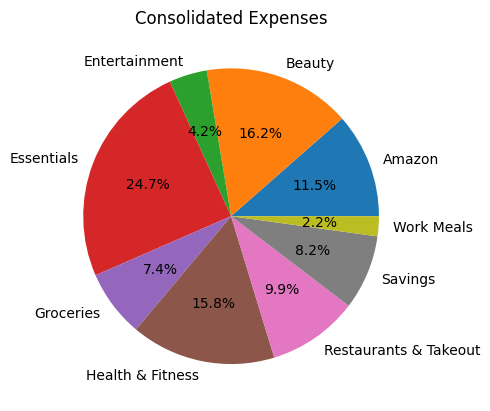

In [12]:
grouped_df = spending.groupby('Category', as_index=False)['Amount'].sum()
plt.pie(grouped_df['Amount'], labels=grouped_df['Category'], autopct='%1.1f%%')
plt.title('Consolidated Expenses')
plt.show()


In [13]:
# Change the data type for column 'Date' to the type date
spending['Date'] = pd.to_datetime(spending['Date'])

<Axes: xlabel='Month'>

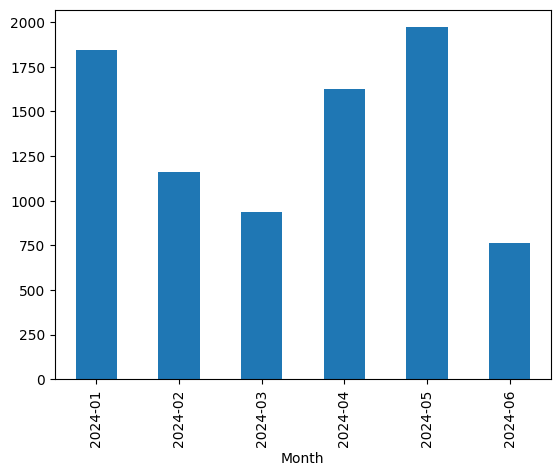

In [14]:
spending['Month'] = spending['Date'].dt.to_period('M')
monthly_spending = spending.groupby('Month')['Amount'].sum().reset_index()
monthly_spending.columns = ['Month', 'Total Spending']
monthly_spending.plot(x='Month', y='Total Spending', kind='bar', legend=False)

<Axes: xlabel='Category'>

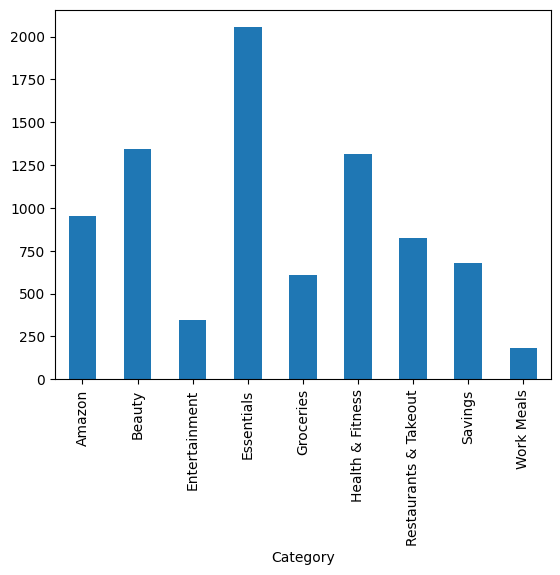

In [15]:
spending_by_categories = spending.groupby('Category')['Amount'].sum()
spending_by_categories.plot(x='Category', y='Total Spending', kind='bar', legend=False)

     Month  Total Spending
0  2024-01         1844.31
1  2024-02         1158.72
2  2024-03          937.09
3  2024-04         1627.48
4  2024-05         1971.74
5  2024-06          762.34


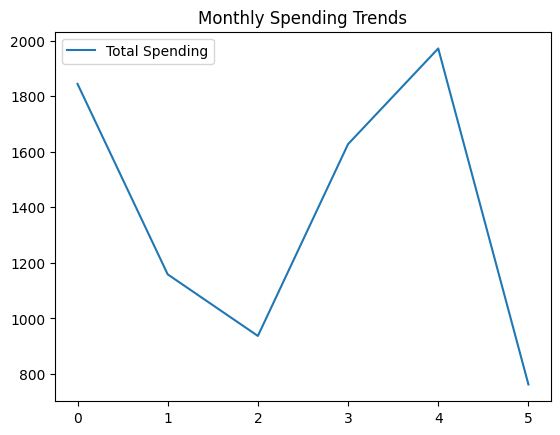

In [16]:
monthly_spending.plot(kind="line", title="Monthly Spending Trends")
print(monthly_spending)

There appears to be an increase in my spending during April. What could be driving this change? Let’s take a closer look at the data for April to analyze the potential reasons behind this increase.

Category
Amazon                   261.21
Beauty                   425.36
Entertainment             41.32
Essentials               123.42
Groceries                132.01
Health & Fitness         341.84
Restaurants & Takeout    187.83
Savings                  105.74
Work Meals                 8.75
Name: Amount, dtype: float64


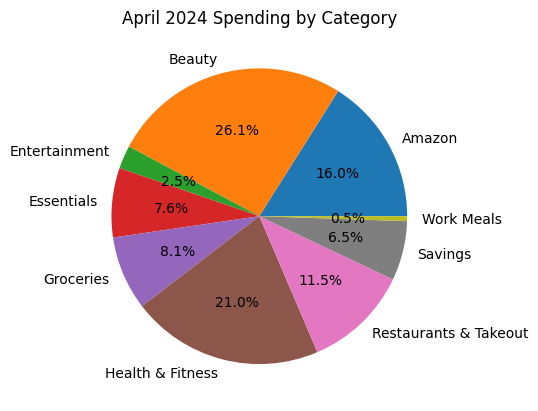

In [17]:
spending["Date"] = pd.to_datetime(spending["Date"])
april_data = spending[(spending["Date"].dt.month == 4)]
april_spending_by_category = april_data.groupby("Category")["Amount"].sum()
print(april_spending_by_category)
april_spending_by_category.plot(kind="pie", autopct="%.1f%%", ylabel="", title="April 2024 Spending by Category")

plt.show()


In April 2024, I spent a lot on beauty items. Let's see for ourselves who the retailers were.

In [18]:
april_data[april_data['Category'] == 'Beauty']

,Date,Description,Amount,Category,Month
139,2024-04-29,RETAIL PURCHASE PAYPAL *UNICE 178.42 CAD @ 1....,178.42,Beauty,2024-04
150,2024-04-22,RETAIL PURCHASE PAYPAL *GROUPED,81.00,Beauty,2024-04
171,2024-04-11,RETAIL PURCHASE GARAGE #2,34.44,Beauty,2024-04
182,2024-04-05,RETAIL PURCHASE PAYPAL *GROUPED,40.20,Beauty,2024-04
197,2024-04-01,RETAIL PURCHASE PAYPAL *GROUPED,91.30,Beauty,2024-04


Now I have a clearer understanding: the increased spending in April was primarily due to purchases on hair care and clothing while preparing for a trip later in the year. On the other hand, I want to understand why my spending significantly decreased in June. That month could serve as a model for improving my financial habits. What did I do differently to achieve such a reduction?

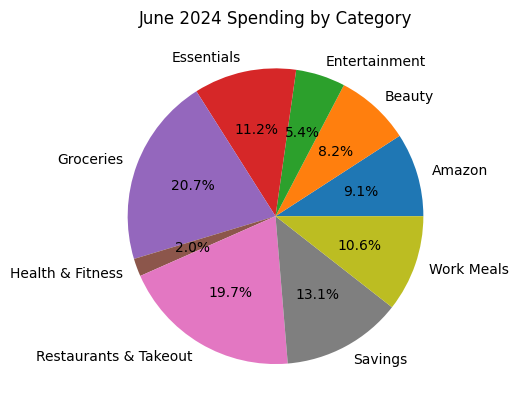

Category
Amazon                    69.73
Beauty                    62.50
Entertainment             41.32
Essentials                85.53
Groceries                157.67
Health & Fitness          14.89
Restaurants & Takeout    150.20
Savings                  100.00
Work Meals                80.50
Name: Amount, dtype: float64


In [19]:
june_data = spending[(spending["Date"].dt.month == 6)]
june_spending_by_category = june_data.groupby("Category")["Amount"].sum()
june_spending_by_category.plot(kind="pie", autopct="%.1f%%", ylabel="", title="June 2024 Spending by Category")
plt.show()
print(june_spending_by_category)

According to the data at hand, the decrease in my overall spending for June wasn’t a result of improved financial habits. Instead, it was due to the absence of payments to my trainer and nutritionist (categorized under Health & Fitness), while spending on takeout remained consistent, or even increased. Let’s confirm this observation by comparing how my spending changed between May and June across different categories.

<Axes: title={'center': 'May 2024 Spending by Category'}>

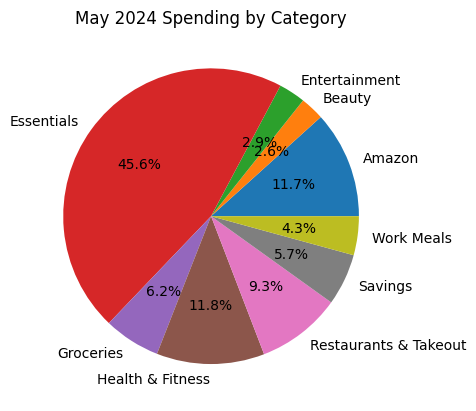

In [20]:
# May data
may_data = spending[(spending["Date"].dt.month == 5)]
may_spending_by_category = may_data.groupby("Category")["Amount"].sum()
may_spending_by_category.plot(kind="pie", autopct="%.1f%%", ylabel="", title="May 2024 Spending by Category")

In [21]:
may_essentials = may_data[may_data["Category"] == "Essentials"]
max_transaction = may_essentials.loc[may_essentials["Amount"].idxmax()]
print(f'CATEGORY OR ENTITY FOR WHICH I PAID THE MOST AMOUNT IN MAY: {max_transaction["Description"]}') # School

CATEGORY OR ENTITY FOR WHICH I PAID THE MOST AMOUNT IN MAY: Internet Banking INTERNET BILL PAY  UNIVERSITE DU QUEBEC -MON


In [22]:
spending_changes_may_june = june_spending_by_category - may_spending_by_category
print(spending_changes_may_june)

Category
Amazon                  -160.88
Beauty                    10.92
Entertainment            -16.09
Essentials              -814.28
Groceries                 35.79
Health & Fitness        -217.74
Restaurants & Takeout    -32.29
Savings                  -11.48
Work Meals                -3.35
Name: Amount, dtype: float64


On the month of May, I had to pay for school, which explains the decrease in my spending in the Essentials category. Again, I did not have consultations with any health professional in the month of June. However, i did pay a little more for groceries, and a little less for takeout.

Another month where my spending was lower was the month of March, which is even more interesting for seeing trends, since i did have

Category
Amazon                    82.95
Beauty                   105.01
Entertainment             41.32
Groceries                 58.00
Restaurants & Takeout    107.70
Savings                  105.74
Name: Amount, dtype: float64


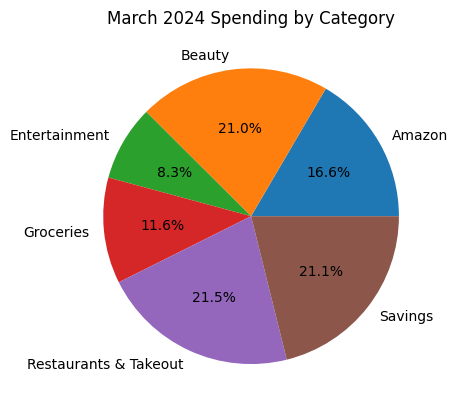

In [23]:
march_data = spending[(spending["Date"].dt.month == 2)]
march_spending_by_category = march_data.groupby("Category")["Amount"].sum()
# Remove essentials, monthly spendings
march_spending_by_category = march_spending_by_category.drop(['Essentials', 'Health & Fitness'])
march_spending_by_category.plot(kind="pie", autopct="%.1f%%", ylabel="", title="March 2024 Spending by Category")
print(march_spending_by_category)

The essentials and Hea

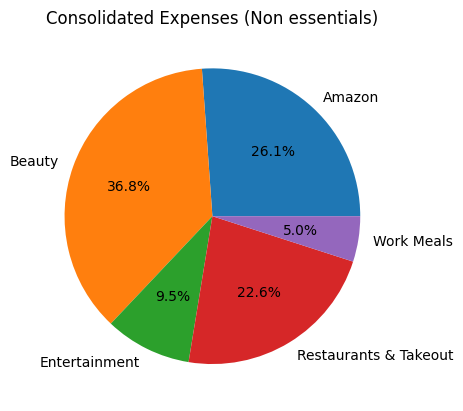

In [24]:
filtered_df = spending[~spending['Category'].isin(['Essentials', 'Health & Fitness', 'Savings', 'Groceries'])]
grouped_df = filtered_df.groupby('Category', as_index=False)['Amount'].sum()
plt.pie(grouped_df['Amount'], labels=grouped_df['Category'], autopct='%1.1f%%')
plt.title('Consolidated Expenses (Non essentials)')
plt.show()


So I would need to work on diminishing Beauty expenses, Amazon expenses (which many fit in the beauty category), and Restaurants as well.

In [31]:
print(spending.describe())

                                Date      Amount       Month
count                            299  299.000000  299.000000
mean   2024-04-07 19:54:22.876254208   27.764816    3.762542
min              2024-01-03 00:00:00    0.150000    1.000000
25%              2024-02-23 00:00:00    6.610000    2.000000
50%              2024-04-15 00:00:00   14.890000    4.000000
75%              2024-05-21 00:00:00   25.000000    5.000000
max              2024-06-28 00:00:00  782.070000    6.000000
std                              NaN   55.815500    1.745695


# Linear Regression

In [47]:
#  Prepare X and y for Regression
monthly_totals = spending.groupby(spending["Date"].dt.to_period("M"))["Amount"].sum()
X = monthly_totals.index.to_timestamp().month.values.reshape(-1, 1)
y = monthly_totals.values # What I am predicting, the total spending per month

#  Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Model
lm = LinearRegression()
lm.fit(X_train, y_train)

# Predict Spending for Test Data
spending_predictions = lm.predict(X_test)

# Coefficients and intercept
print("Coefficient:", lm.coef_)
print("Intercept:", lm.intercept_)

Coefficient: [-17.999]
Intercept: 1405.6580000000001


The model predicts that my spending decreases by around 18 dollars every month.

### Regression Evaluation Metrics

In [49]:
from sklearn.metrics import r2_score

print('MAE:', metrics.mean_absolute_error(y_test, spending_predictions)) # Average error
print('MSE:', metrics.mean_squared_error(y_test, spending_predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, spending_predictions)))
print("R²:", r2_score(y_test, spending_predictions))

MAE: 333.79549999999995
MSE: 126512.90970049993
RMSE: 355.6865329197887
R²: -0.07662853680283122


### **Interpretation of Results**
After applying linear regression to analyze the relationship between my monthly spending and the passage of time (months), the model results revealed a lack of any meaningful correlation between the two. Here's the breakdown:

1. **Mean Absolute Error (MAE):**
   - On average, the model's predictions were **off by about $333.80** compared to the actual values. This means the model struggled to accurately predict spending trends.

2. **Mean Squared Error (MSE):**
   - The **MSE was $126,512**, which indicates the model's errors were significantly magnified when squared. This is largely influenced by larger errors in the data.

3. **Root Mean Squared Error (RMSE):**
   - The **RMSE was $355.69**, which brings the error back to the same unit as the spending amounts. This reinforces the idea that the model's predictions deviated heavily from the actual spending values.

4. **R² (R-Squared):**
   - The **R² score of -0.077** shows that the model performed worse than a baseline model that simply predicted the average spending for all months. This confirms that the relationship between months and spending is essentially **nonexistent**.

In fact, linear regression doesn't work in this case because my spending doesn't follow a clear, consistent linear trend over time (months, in this case). Factors like irregular spending patterns, situational expenses (e.g., trips, emergencies), and external influences (holidays, sales) make it harder for a linear model to fit the data accurately. Linear regression assumes a steady, predictable relationship, which my inconsistent spending habits don't provide.

### **Conclusion**
These results highlight that my spending habits do not follow any predictable, time-based trend. Whether it’s January, May, or June, my spending doesn’t seem to correlate with the month or passage of time. This reinforces what I already know about myself : I am a very inconsistent spender, and external factors like time don’t influence my habits much.

 I’ll explore other machine learning approaches (e.g., clustering or outlier detection) that are better suited for analyzing inconsistent spending patterns.